In [185]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import math
import numpy as np

#Histogram h^v
H = [2,8,17,19,24,28,34,42,45,46,33,29,21,13,9,5,3,2,1,1]


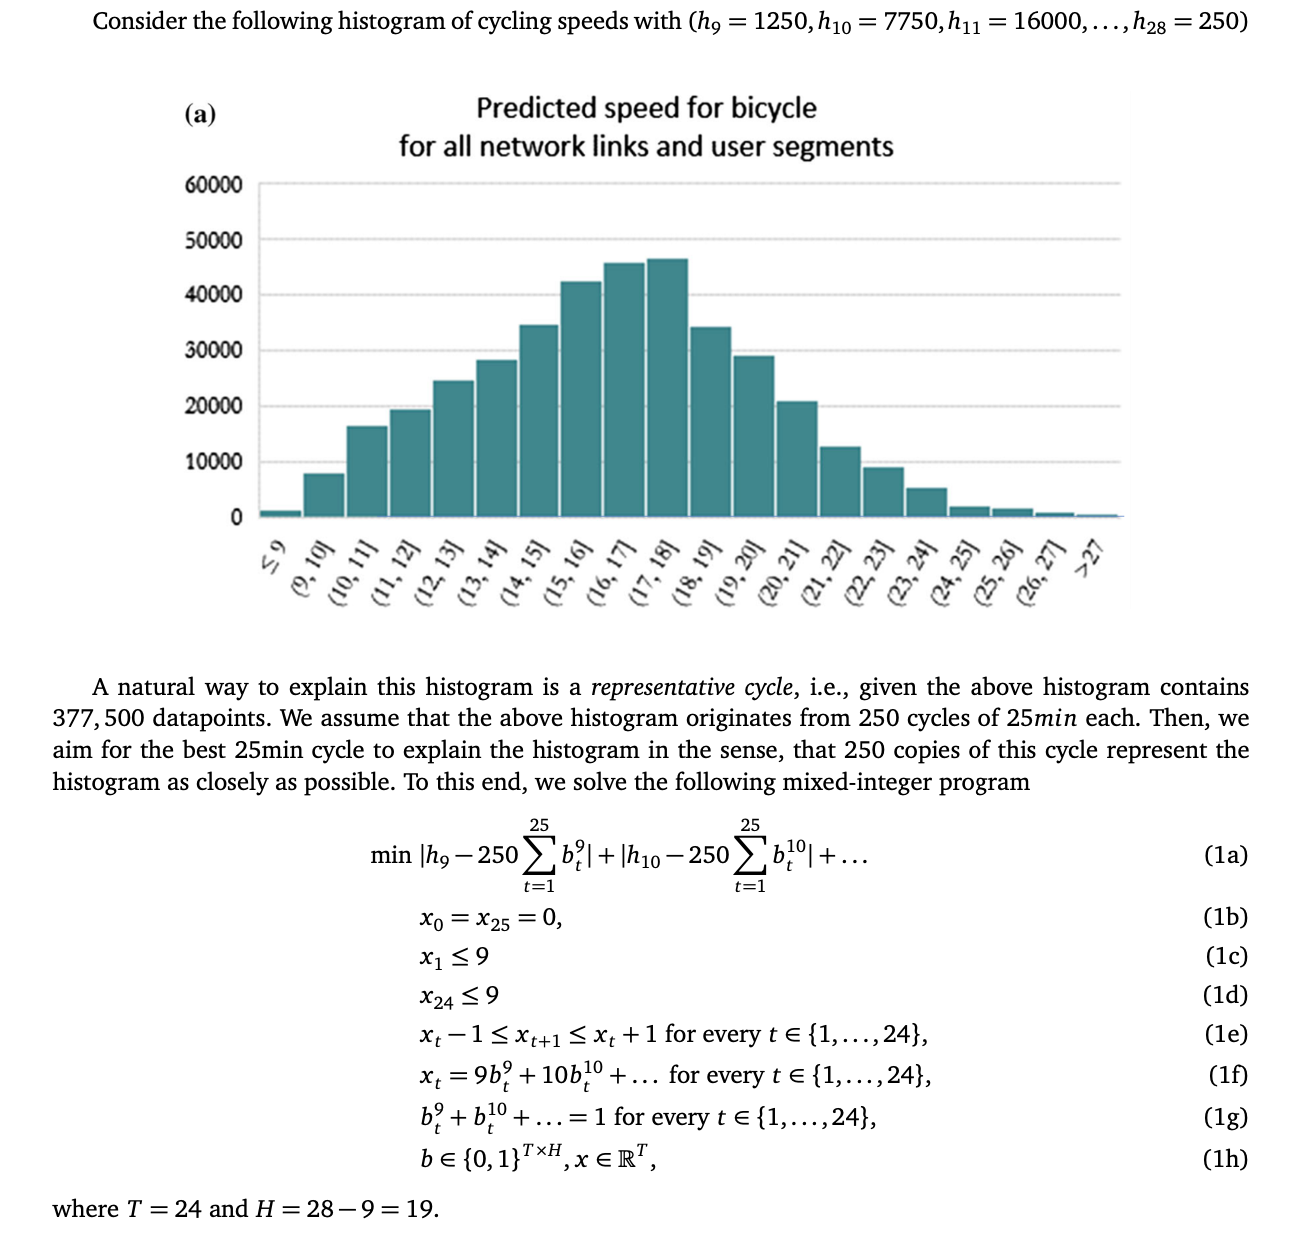

In [186]:
from IPython.display import Image
display(Image(filename='DF_topic.png'))


Trial for DF MIP1

I have used "histogram" as above (ish 1/1000) and C = 0.25 instead of 250

x_0 and x_25 is excluded - reasons being:
        - x_0 contributes nothing as far as I can tell
        - x_25 force x_24 <= 1 ... => it would take 10 minutes to break from 10km/h
        
        
This also does not allow for (specific) speeds below 9/above 28, since they would give the same objective value as 9/28. If we want to include x_0 and x_25 this would need to be added, at least for v < 9
    v<9: add b,x var for each v in (0,8), set u+[9] >= H[0] - C*(sum(t in (0,24))sum(v in (0,9)) b_t^v).. etc
    v>28: set v_max, repeat above steps, i.e.,  u+[28] >= H[28] - C*(sum(t in (0,24))sum(v in (24,v_max)) b_t^v)
    
the 1km/h constr. on speed means that: v < 20, 
(in this test run it never reaches above v=12)
x(t) <= 9 + min(24-t, t-1)


The mirror is of course also a solution, data/idea of difference in behaviour in beginning/end would give less symmetric cycle - if that is desirable. 


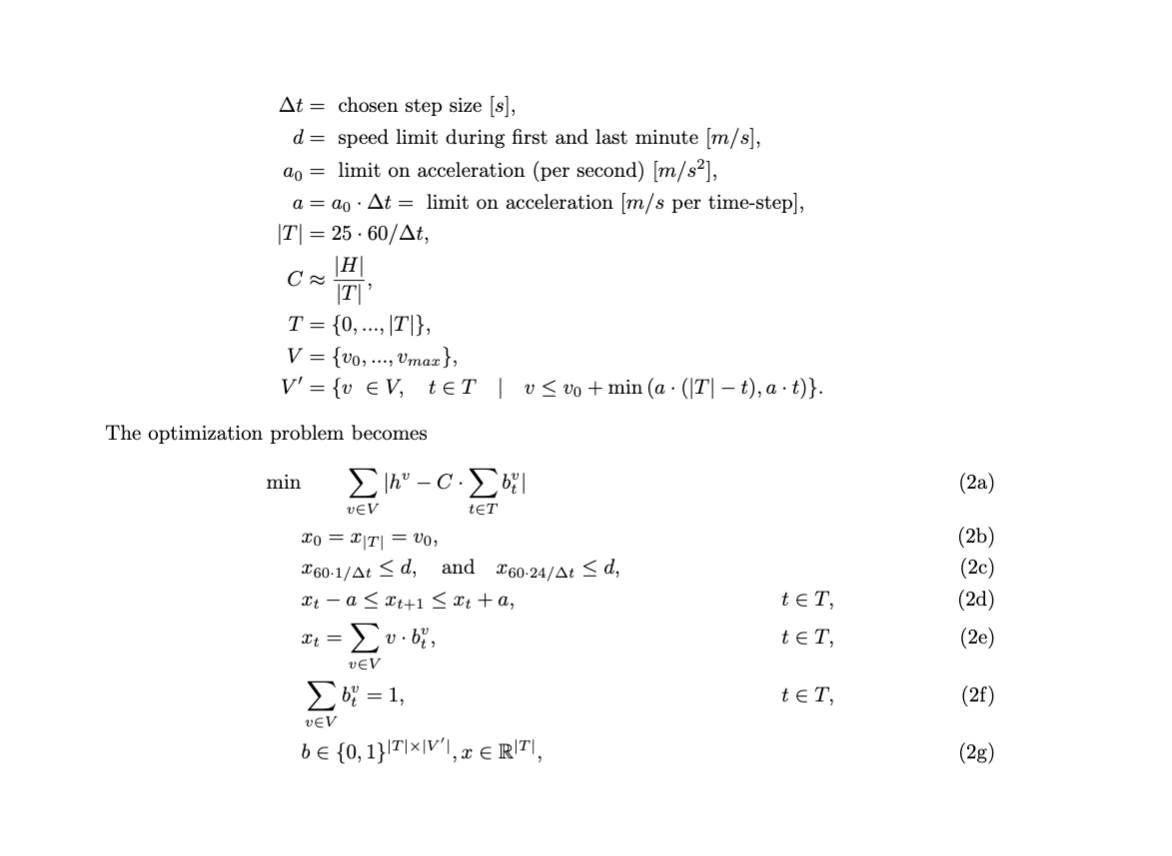

In [187]:
from IPython.display import Image
display(Image(filename='problem_formulation_1_2.png'))

In [218]:
def check_a(a, vel):
    diff_check = []
    old = vel[0]
    for elem in vel:
        diff_check.append(abs(elem-old))
        #print(elem-old)
        old = elem
    max_step = max(diff_check)
    if a < max_step:
        a = math.ceil(max_step*100)/100
        print("Acceleration to low for current bin size, new a = " + str(a))
    return a

In [219]:
cycle_len = 25 #in minutes; length of one cycle #dont change
dt = 1 #in seconds; stepsize; choose a divisor of 60 so that "T" and "one_minute" are integer

T = int(cycle_len*60/dt) #total number of time steps

a_0 = 1000/(60*60*60) #in m/s per second; acceleration/deceleration limit
#d = 2.5 #in m/s; speed limit during first and last minute; not fully implemented currently; 
        #2.5m/s corresponds to 9 km/h from OG problem

num_of_datapoints = sum(H) #number of datapoints
a = round(a_0*dt,2) #calculate consequence of a_0 per time step. 
                    #MAKE SURE THAT A IS LARGE ENOUGH TO BE ABLE TO CHANGE SPEED BETWEEN STEPS!!!
                    #added solution to this below func check_a

        
one_minute = int(60/dt) #gives the # of time-steps that equals a minute


#Below; Handle change to m/s
#because velocities are no longer integer we will have to refer to two different velocities:
#the index of the velocity, and the actual velocity (for t, these are the same)
#to increase legibility, v will henceforth be the actual velocity, and i the index. 
#specifically "v" in "vel" will be velocity
#and "i" in "vel_idx" will be its index
vel_km_h = [v for v in range(9,29)] #current data is in km/h so this will be converted below

vel = [] #[m/s] read from data, when available
for elem in vel_km_h:
    vel.append(round(elem*10/36,3))

a = check_a(a, vel)

    
num_of_vel = len(vel) #number of diff. velocities

v_0 = vel[0]

times = [t for t in range(0,T+1)] #create a vector with all timesteps t
vel_idx = [i for i in range(0,num_of_vel)] #create a vector of idx for velocities 
                                            #because not all vel. int. - bin size etc.
                                            #wait until data i available to set in stone
        

C = num_of_datapoints/(T*2) #scale C so that number of *actual* observations (|H|)..
                             #..roughly coincides with total observations in model (|T|)
                             #this is now further scaled by 2, why this works I do not know, will find out
    
#construct tuplets (time, velocity) but only if b(t,v) *can* be true:
#corresponds to our definition of V'
#currently NOT implemented for constraint (c), only for (b)
#Does not alter solution, simply decreases computation (# of binary variables)
tv_pair = [(t,i) for t in times for i in vel_idx if vel[i] <= v_0 + a*min(T-t, t)]


#construct velocity coefficients
#this is so that we can utilize gurobi function "prod" for easy implementation of constraint (e) later on
coeff = {}
for j in range(len(tv_pair)):
    coeff.update({tv_pair[j]: vel[tv_pair[j][1]]}) #here we assign the velocity "v" to all tuples 
                                              #(t=j, v), j=1,..,T


Acceleration to low for current bin size, new a = 0.28


In [220]:

#model
try:
    m = gp.Model("DF")

    b = m.addVars(tv_pair, vtype=GRB.BINARY, name="b") #b(t,i) binary variables (if = 1; choose velocity "v" at time "t")
    x = m.addVars(times, name="x") #velocity at time t 
    
    
    # diff, u and obj together corresponds to (a) - the objective function:
    diff = m.addVars(vel_idx, name="diff")   #diff(i) = h(i) - C*sum(t, b(t,i)) - see constraint "def_diff"
    u = m.addVars(vel_idx, name="u")         #u(i) = abs(diff(i)) - see constraint "abs_diff"
    obj = sum(u[i] for i in vel_idx)         #objective = sum(i, u(i))
    
    m.setObjective(obj, GRB.MINIMIZE)
    
    #constraints that help define the variables u(v) in the objective function:
    m.addConstrs((diff[i] == H[i] - C*b.sum("*",i) for i in vel_idx), "def_diff")
    m.addConstrs((u[i] == gp.abs_(diff[i]) for i in vel_idx), "abs_diff")
    
    
    #constraint (b);
    m.addConstr((x[0] == v_0), "start") #initial speed = v_0
    m.addConstr((x[T] == v_0), "end") #final speed = v_0  
    
    #m.addConstr((b[0,0] == 1), "start") #initial speed = v_0
    #m.addConstr((b[T,0] == 1), "end") #final speed = v_0  
    
    #constraint (c); 
    #m.addConstr((x[t] <= d for t in times if t <= one_minute), "first_minute") #limit speed during first minute
    #m.addConstr((x[t] <= d for t in times if t >= T-one_minute), "last_minute") #limit speed during last minute
          
    #constraint (d);
    m.addConstrs((x[t] - a <= x[t+1] for t in times if t <= T-1), "accelerate") #increase by max a/timestep
    m.addConstrs((x[t+1] <= x[t] + a for t in times if t <= T-1), "decelerate") #decrease by max a/timestep
          
    #constraint (e)
    m.addConstrs((b.prod(coeff,t,"*") == x[t] for t in times), "speed") #set speed for time t

    #constraint (f);
    m.addConstrs((b.sum(t,"*") == 1 for t in times), "binary") #keep tack of binary variables
    

    
    m.optimize()
    #for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')



Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6024 rows, 31181 columns and 96443 nonzeros
Model fingerprint: 0x673234bb
Model has 20 general constraints
Variable types: 1541 continuous, 29640 integer (29640 binary)
Coefficient statistics:
  Matrix range     [1e-01, 8e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 5e+01]
Presolve removed 18 rows and 30 columns
Presolve time: 0.43s
Presolved: 6006 rows, 31151 columns, 94910 nonzeros
Variable types: 1507 continuous, 29644 integer (29636 binary)
Found heuristic solution: objective 190.8726667

Root relaxation: cutoff, 6594 iterations, 0.43 seconds (0.25 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0    

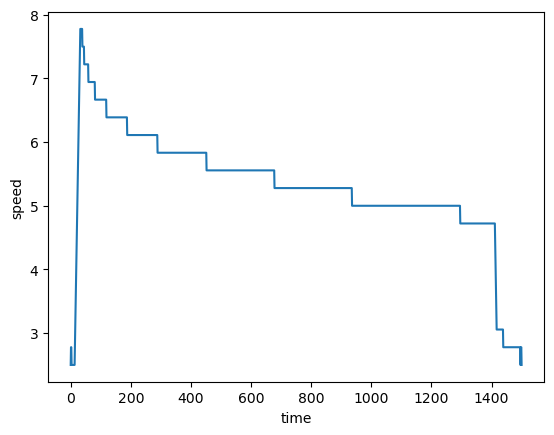

In [221]:
lr = m.getAttr("X", x)
plt.plot(list(lr.keys()),list(lr.values()))
plt.xlabel("time")
plt.ylabel("speed")
#plt.xticks(np.arange(0, 25.1, step=5))
plt.show()

In [226]:
#example of how to get attributes from solution vectors
u_fin = m.getAttr("X", u)
u_fin = list(u_fin.values())
u_fin = [round(el) for el in u_fin]
print(u_fin)
print(H)
print(C)

[0, 0, 14, 19, 24, 28, 34, 42, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 8, 17, 19, 24, 28, 34, 42, 45, 46, 33, 29, 21, 13, 9, 5, 3, 2, 1, 1]
0.12733333333333333


In [224]:
#example of how to get attributes from solution vectors
x_fin = m.getAttr("X", x)
x_fin = list(x_fin.values())
x_fin = [round(el) for el in x_fin]


In [225]:
#Just some different ways to take absolute values in gurobi    
    
    ### NORM
    #u = m.addVar(name="u")
    #obj = u
    #m.addConstr((u == gp.norm(diff, 1.0)), "abs")
    
    ### DIY
    #m.addConstrs((diff[v] - u[v] <= 0 for v in vel), "abs+") #if |h^v - sum_t(b^v)| > 0
    #m.addConstrs((-diff[v] - u[v] <= 0 for v in vel), "abs-") #if |h^v - sum_t(b^v)| < 0

Below is the first model, keeping it around a little longer for some testing.

In [161]:
times = [t for t in range(1,25)] #(NOTE x_0 and x_25 not included)
vel = [v for v in range(9,29)]
C = 0.25 #now 0.25 but 250 in OG


#construct tuplets (time, velocity)
#tv_pair = [(t,v) for t in times for v in vel]
tv_pair = [(t,v) for t in times for v in vel if v <= 9 + min(len(times)-t, t-1)]

#construct velocity coefficients
coeff = {}
for i in range(len(tv_pair)):
    coeff.update({tv_pair[i]: tv_pair[i][1]})

    
#model
try:
    m = gp.Model("DF")

    b = m.addVars(tv_pair, vtype=GRB.BINARY, name="b") #binary variables (1 = choose velocity "v" at time "t")
    x = m.addVars(times, name="x") #velocity at time t
    u = m.addVars(vel, name="u") #abs value
    diff = m.addVars(vel, name="diff")

    obj = sum(u[v] for v in vel) #objective
    m.setObjective(obj, GRB.MINIMIZE)
    
    m.addConstrs((diff[v] == H[v - 9] - C*b.sum("*",v) for v in vel), "abs")
    
    m.addConstrs((u[v] == gp.abs_(diff[v]) for v in vel))
    
    ### NORM
    #u = m.addVar(name="u")
    #obj = u
    #m.addConstr((u == gp.norm(diff, 1.0)), "abs")
    
    ### DIY
    #m.addConstrs((diff[v] - u[v] <= 0 for v in vel), "abs+") #if |h^v - sum_t(b^v)| > 0
    #m.addConstrs((-diff[v] - u[v] <= 0 for v in vel), "abs-") #if |h^v - sum_t(b^v)| < 0

    m.addConstrs((b.sum(t,"*") == 1 for t in times), "binary") #keep tack of binary variables

    m.addConstrs((b.prod(coeff,t,"*") == x[t] for t in times), "speed") #set speed for time t

    m.addConstr((x[1] <= 9), "start") #initial speed
    m.addConstr((x[len(times)] <= 9), "end") #final speed
    
    m.addConstrs((x[t] - 1 <= x[t+1] for t in times if t <= 23), "increase") #increase by max 1
    m.addConstrs((x[t+1] <= x[t] + 1 for t in times if t <= 23), "decrease") #decrease by max 1
    
    m.optimize()
    #for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) M-5Y31 CPU @ 0.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 116 rows, 220 columns and 606 nonzeros
Model fingerprint: 0x0a971219
Model has 20 general constraints
Variable types: 64 continuous, 156 integer (156 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 39 rows and 51 columns
Presolve time: 0.01s
Presolved: 77 rows, 169 columns, 393 nonzeros
Variable types: 0 continuous, 169 integer (150 binary)
Found heuristic solution: objective 376.0000000

Root relaxation: cutoff, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       3